# 0.0. IMPORTS

In [1]:
import                             pickle
import                             warnings
import                             datetime
import                             glob
import pandas                      as pd
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import statsmodels.api             as sm
from sklearn.metrics               import mean_absolute_error,mean_squared_error,r2_score
from minio                         import Minio
from fbprophet                     import Prophet
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal      import seasonal_decompose

warnings.filterwarnings('ignore')

/home/andriw/anaconda3/envs/EnvAcao2/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1. Help Functions

In [2]:
# Função que separa os dados em treino e teste
def data_preparation(dataset,feature):
    
    # Atribuindo os dados a variável X
    series = dataset[feature]
    X = series.values

    # Definindo o tamanho do dataset de treino e teste
    train_size = int(len(X) * 0.50)

    # Cria os conjuntos de treino e teste
    train = X[0: train_size]
    test  = X[train_size:]
    return [train,test]


# Função de treinamento do modelo ARIMA
def treinando_o_modelo_arima(order): 
    
    # Cria a variável history
    history = [x for x in train]

    # Cria lista de previsões
    predictions = list()

    # Inicia Walk-Forward
    for t in range(len(test)):

      # Difference data
      meses_no_ano = 12
      diff = difference(history, meses_no_ano)

      # Cria um modelo ARIMA com os dados de history
      model = sm.tsa.arima.ARIMA(diff, order=order)

      # Treina o modelo ARIMA
      model_fit = model.fit()

      # A variável valor_predito recebe o valor previsto pelo modelo
      valor_predito = model_fit.forecast()[0]

      # valor_predito recebe o valor revertido (escala original)
      valor_predito = inverse_difference(history, valor_predito, meses_no_ano)

      # Adiciona o valor predito na lista de predições
      predictions.append(valor_predito)

      # A variável valor_real recebe o valor real do teste
      valor_real = test[t]

      # Adiciona o valor real a variável history
      history.append(valor_real)
        
    return [test,predictions]


# Função de treinamento do modelo SARIMAX
def treinando_o_modelo_sarimax(order,seasonal_order): 
    
    # Cria a variável history
    history = [x for x in train]

    # Cria lista de previsões
    predictions = list()

    # Inicia Walk-Forward
    for t in range(len(test)):

      # Difference data
      meses_no_ano = 12
      diff = difference(history, meses_no_ano)

      # Cria um modelo SARIMAX com os dados de history
      model = sm.tsa.statespace.SARIMAX(diff, order=order, seasonal_order=seasonal_order)

      # Treina o modelo ARIMA
      model_fit = model.fit()

      # A variável valor_predito recebe o valor previsto pelo modelo
      valor_predito = model_fit.forecast()[0]

      # valor_predito recebe o valor revertido (escala original)
      valor_predito = inverse_difference(history, valor_predito, meses_no_ano)

      # Adiciona o valor predito na lista de predições
      predictions.append(valor_predito)

      # A variável valor_real recebe o valor real do teste
      valor_real = test[t]

      # Adiciona o valor real a variável history
      history.append(valor_real)
        
    return [test,predictions]


# Função que compara as previsões com graficamente
def comparacao_das_previsoes(test,predictions):
    plt.plot(test)
    plt.plot(predictions, color='red')
    return plt.show


# Função que calcula as métricas do modelo
def ml_error(model_name,y,yhat):

  mae     = mean_absolute_error(y,yhat)
  mape    = mean_absolute_percentage_error(y,yhat)
  rmse    = np.sqrt(mean_squared_error(y,yhat))
  r2score = r2_score(y,yhat)

  return pd.DataFrame({    'Model Name':  model_name,
                           'MAE':         mae,
                           'MAPE':        mape,
                           'RMSE':        rmse  ,
                           'R2-SCORE':    r2score     },index=[0])


# Função que calcula o MAPE
def mean_absolute_percentage_error(y,yhat):
  return np.mean(np.abs((y-yhat)/y))


# Cria a função que faz a diferenciação
def difference( dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff


# Cria a função que reverte o valor diferenciado para o original
def inverse_difference( history, previsao, interval=1):
  return previsao + history[-interval]

## 0.2. Carregando os dados

In [3]:
# Chave de acesso ao datalake
client = Minio(  "localhost:9000",
                 access_key=   "minioadmin",
                 secret_key=   "minioadmin",
                 secure=        False   )

# Extraindo os dados do datalake
client.fget_object( "processing","dataset.parquet","dataset.parquet")
df_raw = pd.read_parquet("dataset.parquet").set_index('Date')
df_raw.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-20,28.799999,27.950001,28.270000,28.500000,56063300.0,16.945587
2021-10-21,28.180000,26.920000,27.860001,27.450001,101567700.0,16.321278
2021-10-22,27.760000,25.770000,27.100000,27.180000,138384700.0,16.160742
2021-10-25,29.309999,27.650000,27.760000,29.040001,135830600.0,17.266665
2021-10-26,29.230000,28.600000,28.799999,28.760000,57865600.0,17.100178


# 1.0. DATA VISUALIZATION

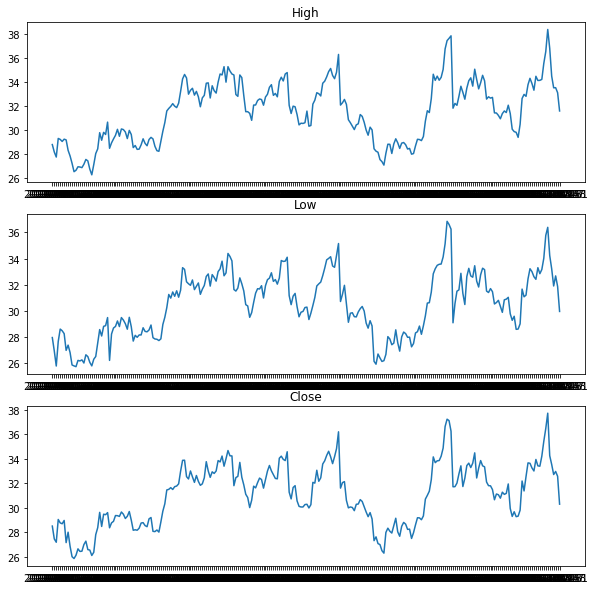

In [4]:
fig = plt.figure(figsize=(10,10))

# High
plt.subplot(3,1,1)
plt.plot(df_raw['High'])
plt.title('High')

# Low
plt.subplot(3,1,2)
plt.plot(df_raw['Low'])
plt.title('Low')

# Close
plt.subplot(3,1,3)
plt.plot(df_raw['Close'])
plt.title('Close')

plt.show()

# 2.0. DATA PREPARATION

In [5]:
# Train and test 
train, test = data_preparation(df_raw,'Close')[0],data_preparation(df_raw,'Close')[1]

# 3.0. MACHINE LEARNING MODELS

## 3.1. Base line - Moving Average (MA)

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,BaseLine,1.781207,0.055867,2.078149,0.312533


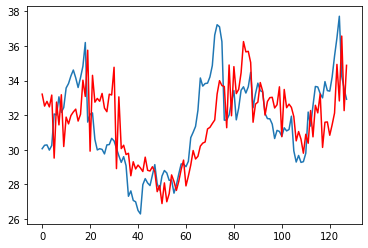

In [20]:
# Training
order=(0,0,1)
test        = treinando_o_modelo_arima(order)[0]
predictions = treinando_o_modelo_arima(order)[1]

# Results
comparacao_das_previsoes(test,predictions)
baseline_results = ml_error('BaseLine',test, predictions)
baseline_results

## 3.2. Autoregressive (AR)

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,AR,1.024753,0.032342,1.370251,0.701119


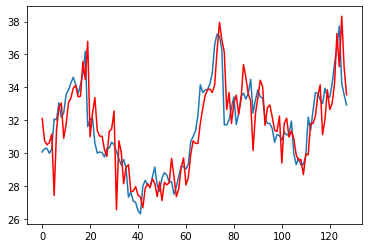

In [21]:
# Training
order=(1,0,0)
test        = treinando_o_modelo_arima(order)[0]
predictions = treinando_o_modelo_arima(order)[1]

# Results
comparacao_das_previsoes(test,predictions)
ar_results = ml_error('AR',test, predictions)
ar_results

## 3.3. Autoregressive Moving Average (ARMA)

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,ARMA,1.032349,0.03259,1.374983,0.699051


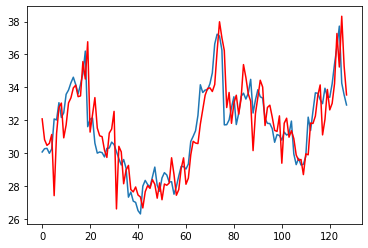

In [22]:
# Training
order = (1,0,1)
test        = treinando_o_modelo_arima(order)[0]
predictions = treinando_o_modelo_arima(order)[1]

# Results
comparacao_das_previsoes(test,predictions)
arma_results = ml_error('ARMA',test, predictions)
arma_results

## 3.4. ARIMA

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,ARIMA,1.008795,0.031811,1.406049,0.685298


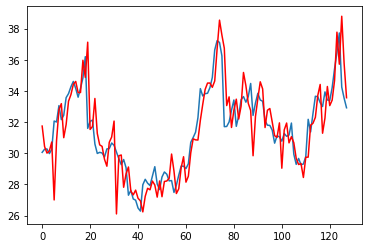

In [23]:
#Training
order = (1,1,1)
test        = treinando_o_modelo_arima(order)[0]
predictions = treinando_o_modelo_arima(order)[1]

# Results
comparacao_das_previsoes(test,predictions)
arima_results = ml_error('ARIMA',test, predictions)
arima_results

## 3.5. SARIMA

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,SARIMA,0.869473,0.027445,1.262973,0.746086


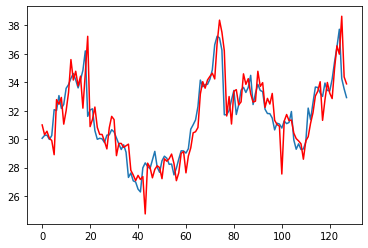

In [24]:
# Training
order = (1,1,1)
seasonal_order = (1,1,1,12)
test        = treinando_o_modelo_sarimax(order,seasonal_order)[0]
predictions = treinando_o_modelo_sarimax(order,seasonal_order)[1]

# Results
comparacao_das_previsoes(test,predictions)
sarima_results = ml_error('SARIMA',test, predictions)
sarima_results

## 3.6. Facebook Prophet

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,FBPROPHET,2.857669,0.084461,3.20827,-4.00233


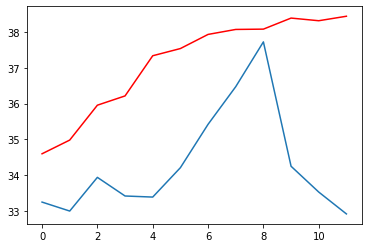

In [26]:
# Separando os dados por meses
series = df_raw['Close']
split_point = len(series) - 12

# Dataset vai conter linhas até o split_point
dataset = series[0:split_point]

# Validation terá dados do split_point em diante
validation = series[split_point:]

# Criando o dataframe de treino
dataframe = pd.DataFrame({'ds': dataset.index, 'y': dataset.values})

# Instancia o objeto prophet
model = Prophet(yearly_seasonality=True, daily_seasonality=True)

# Gerando o modelo
model.fit(dataframe)

# Gerando dados futuros
futuro = model.make_future_dataframe(periods = 12, freq='M')

# Prevendo valores para dados futuros
saida = model.predict(futuro)

# Dataset de validação
validation_df = pd.DataFrame({'ds': validation.index})

# Aplicando o modelo do prophet
saida = model.predict(validation_df)

# Results
comparacao_das_previsoes(validation.values,saida.yhat)
prophet_results = ml_error('FBPROPHET',validation.values, saida.yhat)
prophet_results

## 3.7. Best Models

In [27]:
pd.concat([baseline_results,ar_results,arma_results,arima_results,sarima_results,prophet_results],axis=0).sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,SARIMA,0.869473,0.027445,1.262973,0.746086
0,AR,1.024753,0.032342,1.370251,0.701119
0,ARMA,1.032349,0.032590,1.374983,0.699051
0,ARIMA,1.008795,0.031811,1.406049,0.685298
0,BaseLine,1.781207,0.055867,2.078149,0.312533
0,FBPROPHET,2.857669,0.084461,3.208270,-4.002330


## 3.8. Final model

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,SARIMA,0.869473,0.027445,1.262973,0.746086


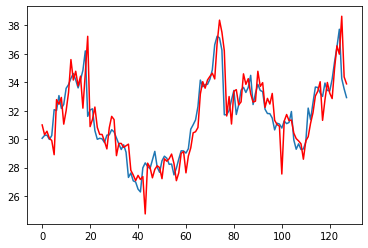

In [28]:
# Best parameters
best_params = {'AR': 1, 'I': 1, 'MA': 1, 'so1': 1, 'so2': 1, 'so3': 1, 'so4': 12}

# Training
order          = (best_params['AR'],best_params['I'],best_params['MA'])
seasonal_order = (best_params['so1'],best_params['so2'],best_params['so3'],best_params['so4'])
test           = treinando_o_modelo_sarimax(order,seasonal_order)[0]
predictions    = treinando_o_modelo_sarimax(order,seasonal_order)[1]

# Results
comparacao_das_previsoes(test,predictions)
sarima_results = ml_error('SARIMA',test, predictions)
sarima_results

# 4.0. TRANSLATION AND INTERPRETATION OF THE ERROR

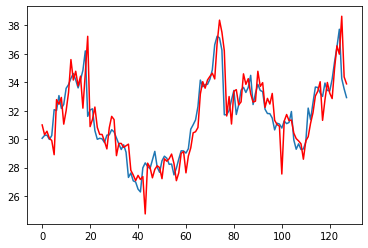

,Model Name,MAE,MAPE,RMSE,R2-SCORE
0,AR,0.869473,0.027445,1.262973,0.746086


In [29]:
# Plot forecast against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Performance
ar_results = ml_error('AR',test, predictions)
ar_results

In [30]:
# Erros residuais
residuals = [test[i] - predictions[i] for i in range(len(test))]

# Convertendo a lista em um dataframe
residuals = pd.DataFrame( residuals)

# Imprime as 5 primeiras linhas
residuals.head()

,0
0,-0.936869
1,-0.051286
2,-0.274139
3,-0.082617
4,0.349017


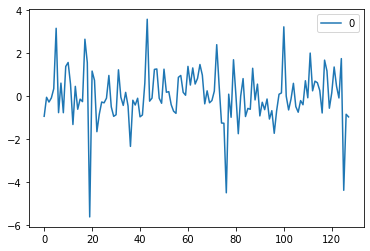

In [31]:
# Plot residuals
residuals.plot()
plt.show()

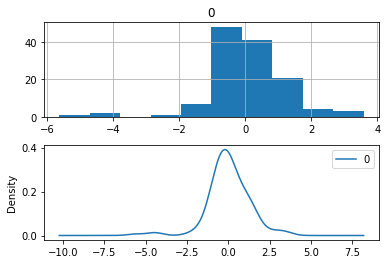

In [32]:
# Plots histograma
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())

plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

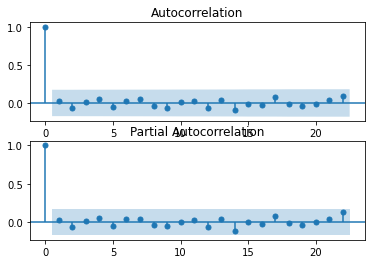

In [33]:
# Plots de autocorrelação
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca())
plt.show()

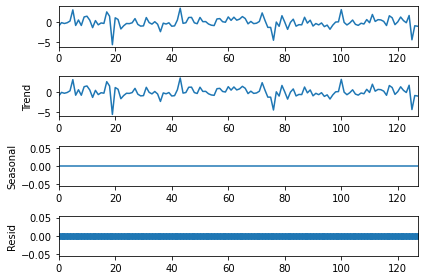

In [34]:
# Decompondo a série de erro residual
result = seasonal_decompose( residuals, model='additive', freq=1)
result.plot()
plt.show()